## What we are going to do?


1. Download the IMDB review dataset
2. Perform necessary preprocessing
3. Convert data into vector (OHE,word2vec,BOW)
4. create a model(RNN, LSTM,Bi-directional LSTM, Stacked LSTM, GRU) using keras, tensorflow or pytorch
5. Compare the performance, which model is Best?### Note: The datset has been taken from: https://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import tarfile
import os
from ipywidgets import FloatProgress

In [2]:
# path_tofile = r"/Users/praveensrivas/Documents/NLP_GEN_AI/Projects/Data/aclImdb_v1.tar.gz"
# extract_to  = os.path.dirname(path_tofile)


# if tarfile.is_tarfile(path_tofile):
#   with tarfile.open(path_tofile) as f:
#     f.extractall(path=extract_to)    #extract

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

#### 1. Reading data, and creating train test dataset

In [111]:
def load_data_from_folder(folder_path, label):
  data = []
  for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
      file_path = os.path.join(folder_path, filename)
      with open(file_path,'r',encoding='utf-8') as file:
        content = file.read()
        data.append((content,label))

  return data

def create_dataset(base_dir):
  train_data = []
  test_data = []

  #Train paths
  train_pos_path = os.path.join(base_dir,'train','pos')
  train_neg_path = os.path.join(base_dir,'train','neg')


  #Test path
  test_pos_path = os.path.join(base_dir,'test','pos')
  test_neg_path = os.path.join(base_dir,'test','neg')


  # Load train data
  train_data.extend(load_data_from_folder(train_pos_path,1))
  train_data.extend(load_data_from_folder(train_neg_path,0))

  # Load test data
  test_data.extend(load_data_from_folder(test_pos_path,1))
  test_data.extend(load_data_from_folder(test_neg_path,0))

  # Convert to Dataframe
  train_df = pd.DataFrame(train_data, columns=['review','label'])
  test_df = pd.DataFrame(test_data, columns=['review','label'])

  return train_df

In [112]:
base_dir = '/Users/praveensrivas/Documents/Datasets/NLP_Datasets/Data/aclImdb'

In [113]:
train_df= create_dataset(base_dir=base_dir)
test_df= create_dataset(base_dir=base_dir)

In [114]:
train_df.shape, test_df.shape

((25000, 2), (25000, 2))

In [115]:
train_df.sample(2)

,review,label
21116,"Before seeing this movie, I would've said that...",0
11703,"In life, we first organize stones (Piedras in ...",1


## 2. Text preprocessing
1. Lowercasing  
2. Remove Punctuation  
3. Tokenization  
4. Remove Stopwords  
5. Remove Numbers  
6. Stemming  
7. Lemmatization  
8. Handling Special Characters  
9. Handling Whitespace

In [117]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load stopwords
stopwords_ = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text by applying the following steps:
    1. Convert to lowercase
    2. Remove punctuation marks, HTML tags, and URLs
    3. Tokenize and remove stopwords
    4. Lemmatize words
    
    Args:
        text (str): The input text to be processed.
        
    Returns:
        str: Cleaned and lemmatized text without stopwords.
    """
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags, content in brackets, URLs, and special characters
    text = re.sub(r'<[^>]*?>|\[.*?\]|https?:\/\/\S+|www\.\S+|[^\w\s]', '', text)
    
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords_]
    
    # Lemmatize words
    wl = WordNetLemmatizer()
    text = " ".join([wl.lemmatize(word) for word in tokens])
    
    return text


In [118]:
train_df['clean_review'] = train_df['review'].apply(preprocess_text)

In [119]:
test_df['clean_review'] = test_df['review'].apply(preprocess_text)

In [120]:
train_df.drop(columns=["review"], inplace=True)
test_df.drop(columns=["review"], inplace=True)

In [121]:
# checking AVG words in reviews
word_count = train_df['clean_review'].apply(lambda x: len(x.split()))
word_count.describe()

count    25000.000000
mean       121.167120
std         91.157393
min          4.000000
25%         65.000000
50%         90.000000
75%        148.000000
max       1429.000000
Name: clean_review, dtype: float64

In [122]:
# # box plot for wordcount
# import matplotlib.pyplot as plt
# plt.boxplot(word_count)
# plt.grid(True)
# plt.show()

`Observation: ` Most of the word count in each review is less then 200

### Word cloud for Positive and Negative

In [123]:
# from wordcloud import WordCloud

# pos_word_list = train_df[train_df['label']==1]['clean_review'].unique().tolist()
# neg_word_list = train_df[train_df['label']==0]['clean_review'].unique().tolist()

# pos_wordcloud = " ".join(pos_word_list)
# neg_wordcloud = " ".join(neg_word_list)

# pos_wordcloud_plot = WordCloud(width=800, height=600, stopwords=stopwords_).generate(pos_wordcloud)
# neg_wordcloud_plot = WordCloud(width=800, height=600, stopwords=stopwords_).generate(neg_wordcloud)


In [124]:
# plt.figure(figsize=(9,9), facecolor=None)
# plt.title("Positive word cloud")
# plt.imshow(pos_wordcloud_plot)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

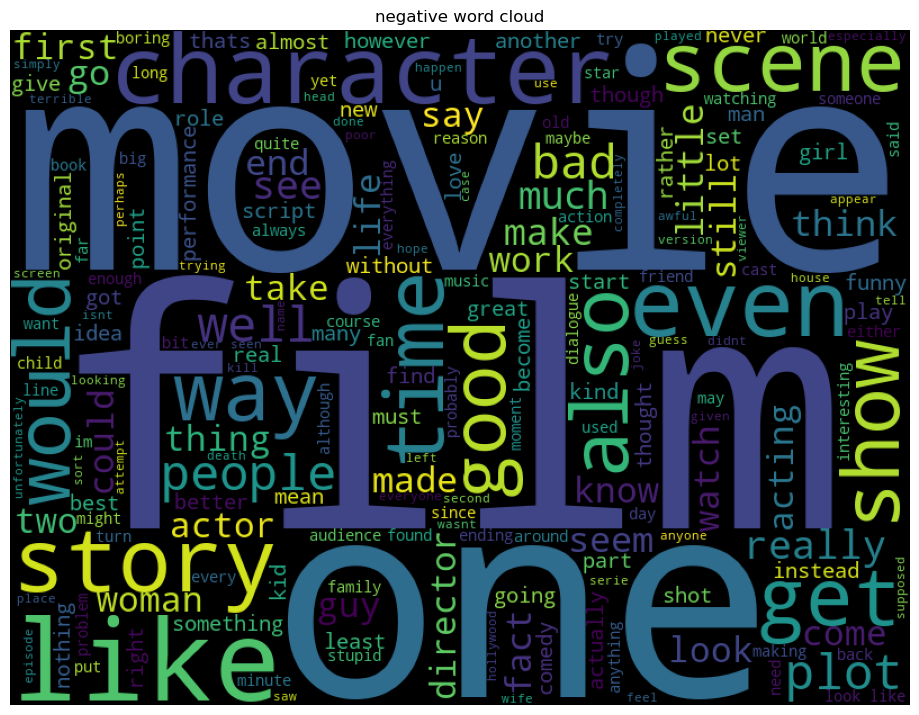

In [17]:
plt.figure(figsize=(9,9), facecolor=None)
plt.title("negative word cloud")
plt.imshow(neg_wordcloud_plot)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Splitting the dataset into train and test

In [127]:
from sklearn.model_selection import train_test_split
train_data = train_df['clean_review']
train_labels = train_df['label']

test_data = test_df['clean_review']
test_labels = test_df['label']

In [128]:
# Assuming `data` is your full dataset and `labels` are corresponding labels
test_data, val_data, test_labels, val_labels = train_test_split(data, labels, test_size=0.4, random_state=42)

In [130]:
# Check sizes
# Print the shapes of each split to verify correctness
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print()
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (25000,)
Validation data shape: (10000,)
Test data shape: (15000,)

Train labels shape: (25000,)
Validation labels shape: (10000,)
Test labels shape: (15000,)


### Usin an LLM for Embedding

- Taking pre-trained LLMs like OpenAI's GPT, BERT, or sentence-transformers (e.g., distilbert-base-uncased, sentence-transformers/all-MiniLM-L6-v2) to extract high-quality embeddings.

In [131]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch, numpy as np
# disable memory overhead
torch.mps.set_per_process_memory_fraction(0.0)
# Check if MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [132]:
# checking for gpu

# !pip install tensorflow-macos
# !pip install tensorflow-metal
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

import tensorflow as tf

# Set memory growth for GPUs before initializing TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("\nMemory growth set for GPUs")
    except RuntimeError as e:
        print("\nError:", e)
else:
    print("Model will use CPU")


Num GPUs Available:  0

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Model will use CPU


In [133]:
# Loading tokenizer to tokenize the sentence
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [197]:
# Loading the model for embedding
embd_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to('mps')  # Use MPS for mac
# Move model to MPS device
embd_model = embd_model.to(device)

In [198]:
# extracting embedding from model
sentences_train = train_data.tolist()
sentences_test = test_data.tolist()
sentences_val = val_data.tolist()

In [168]:
def batch_encode(sentences, tokenizer, model, batch_size=128):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt')
        encoded_input = {key: val.to('mps') for key, val in encoded_input.items()}
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_embeddings = model_output.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)


In [169]:
train_data_embedded = batch_encode(sentences_train, tokenizer, embd_model, batch_size=128)
test_data_embedded = batch_encode(sentences_test, tokenizer, embd_model, batch_size=128)
val_data_embedded = batch_encode(sentences_val, tokenizer, embd_model, batch_size=128)

In [170]:
# Checking the shapes of the embedded data
print("Train data embedded shape:", train_data_embedded.shape)
print("Test data embedded shape:", test_data_embedded.shape)
print("Validation data embedded shape:", val_data_embedded.shape)

Train data embedded shape: (25000, 768)
Test data embedded shape: (15000, 768)
Validation data embedded shape: (10000, 768)


In [171]:
# # Reshape X_train_embedded and X_test_embedded to match (batch_size, 1, 768)
# Reshape the data to have the correct shape (samples, sequence_length, features)
train_embedded1 = np.reshape(train_data_embedded, (train_data_embedded.shape[0], 1, train_data_embedded.shape[1]))  # (25000, 1, 768)
test_embedded1 = np.reshape(test_data_embedded, (test_data_embedded.shape[0], 1, test_data_embedded.shape[1]))  # (15000, 1, 768)
val_embedded1 = np.reshape(val_data_embedded, (val_data_embedded.shape[0], 1, val_data_embedded.shape[1]))  # (10000, 1, 768)

In [172]:
# # Print shapes for debugging
print(f"train_embedded1 shape: {train_embedded1.shape}")
print(f"test_embedded1 shape: {test_embedded1.shape}")
print(f"val_embedded1 shape: {val_embedded1.shape}")

train_embedded1 shape: (25000, 1, 768)
test_embedded1 shape: (15000, 1, 768)
val_embedded1 shape: (10000, 1, 768)


In [235]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the model
model = Sequential()

# LSTM Layer: input_shape is now (1, 768) as we reshaped the data accordingly
model.add(LSTM(150, return_sequences=False, input_shape=(1, 768)))  # Use 768 as the feature size
model.add(Dropout(0.3))



# Dense Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 150)            │       551,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,857 (2.18 MB)

 Trainable params: 570,857 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [236]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Initialize the model
# model = Sequential()

# # Bidirectional LSTM Layer with L2 regularization
# model.add(Bidirectional(LSTM(256, return_sequences=True, 
#                              input_shape=(1, 768), 
#                              kernel_regularizer=l2(0.01), 
#                              recurrent_regularizer=l2(0.01))))  # Bidirectional LSTM for better sequence understanding
# model.add(Dropout(0.7))

# # Additional LSTM Layer for deeper learning
# model.add(Bidirectional(LSTM(128, return_sequences=False, 
#                              kernel_regularizer=l2(0.01), 
#                              recurrent_regularizer=l2(0.01))))
# model.add(Dropout(0.6))

# # Dense Layer with increased units and activation
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.6))

# # Output Layer
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model with a learning rate scheduler
# optimizer = Adam(learning_rate=0.005)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Summary of the model
# model.summary()


In [249]:
# Train the model
history = model.fit(train_embedded1, train_labels, epochs=50, batch_size=200, validation_data=(val_embedded1, val_labels))

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8737 - loss: 0.2938 - val_accuracy: 0.8828 - val_loss: 0.2742
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8785 - loss: 0.2861 - val_accuracy: 0.8871 - val_loss: 0.2651
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8822 - loss: 0.2737 - val_accuracy: 0.8911 - val_loss: 0.2564
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2854 - val_accuracy: 0.8894 - val_loss: 0.2622
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8807 - loss: 0.2769 - val_accuracy: 0.8907 - val_loss: 0.2488
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8893 - loss: 0.2612 - val_accuracy: 0.9007 - val_loss: 0.2337
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8899 - loss: 0.2643 - val_accuracy: 0.9017 - val_loss: 0.2366
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8918 - loss: 0.2531 - val_accuracy: 0.

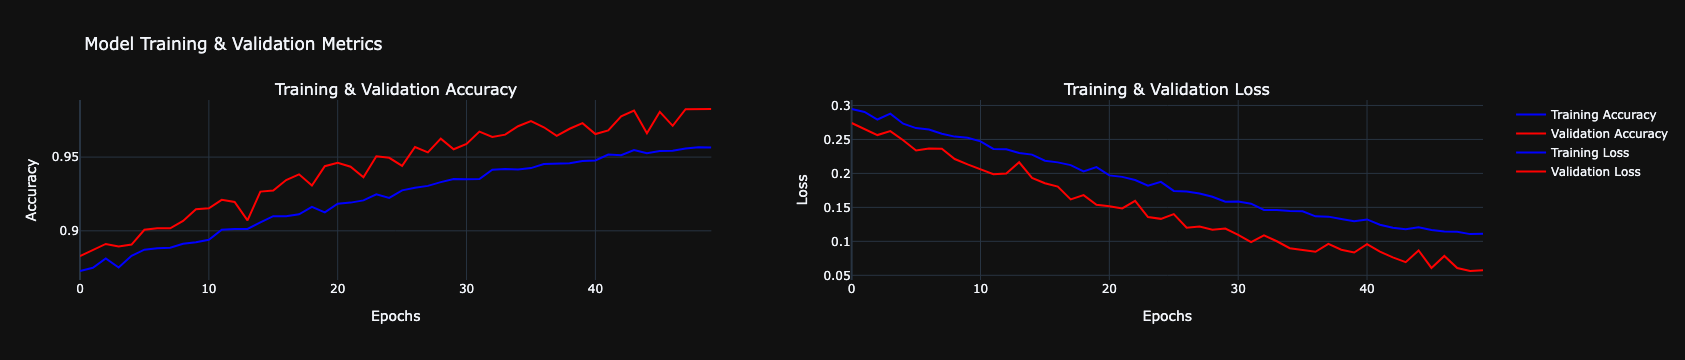

In [250]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Assuming history is the object returned from model.fit()

# Create the figure
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training & Validation Accuracy', 'Training & Validation Loss'))

# Accuracy plot
fig.add_trace(
    go.Scatter(x=list(range(len(history.history['accuracy']))), y=history.history['accuracy'], 
               mode='lines', name='Training Accuracy', line=dict(color='blue')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=list(range(len(history.history['val_accuracy']))), y=history.history['val_accuracy'], 
               mode='lines', name='Validation Accuracy', line=dict(color='red')),
    row=1, col=1
)

# Loss plot
fig.add_trace(
    go.Scatter(x=list(range(len(history.history['loss']))), y=history.history['loss'], 
               mode='lines', name='Training Loss', line=dict(color='blue')),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=list(range(len(history.history['val_loss']))), y=history.history['val_loss'], 
               mode='lines', name='Validation Loss', line=dict(color='red')),
    row=1, col=2
)

# Update layout for better visual appearance
fig.update_layout(
    title="Model Training & Validation Metrics",
    xaxis_title="Epochs",
    yaxis_title="Accuracy",
    xaxis2_title="Epochs",
    yaxis2_title="Loss",
    showlegend=True,
    template="plotly_dark"
)

# Show the plot
fig.show()


In [251]:
from sklearn.metrics import accuracy_score

# Prediction Function
def make_predictions(model, X_data):
    """
    Makes predictions using the trained model on the given input data.
    
    Parameters:
    model: The trained Keras model.
    X_data: Input data for making predictions (should have shape (samples, 1, 768)).
    
    Returns:
    numpy array: Predicted labels (0 or 1) for the input data.
    """
    # Get the model predictions
    predictions = model.predict(X_data)
    
    # Convert predictions to binary labels (0 or 1) by thresholding at 0.5
    predicted_labels = (predictions > 0.5).astype(int)
    
    return predicted_labels

# Evaluation Function
def evaluate_accuracy(model, X_data, y_true):
    """
    Evaluates the model accuracy on the given dataset.
    
    Parameters:
    model: The trained Keras model.
    X_data: Input data for evaluation (should have shape (samples, 1, 768)).
    y_true: True labels for the dataset.
    
    Returns:
    float: Accuracy score.
    """
    # Evaluate the model on the provided dataset
    loss, accuracy = model.evaluate(X_data, y_true, verbose=0)
    
    # Return the accuracy score
    return accuracy

# Example usage:
# 1. Make predictions on the test data
predicted_labels = make_predictions(model, test_embedded1)

# 2. Evaluate the accuracy on the test data
accuracy = evaluate_accuracy(model, test_embedded1, test_labels)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
Accuracy on the test set: 98.53%


In [252]:
def predict_text(model, tokenizer, embedding_model, input_text):
    """
    This function takes an input text, preprocesses it, and makes a prediction using the trained model.
    
    Parameters:
    model: The trained Keras model.
    tokenizer: The tokenizer used during training to process text.
    embedding_model: The model used for generating text embeddings (e.g., BERT).
    input_text: The input text to be classified.
    
    Returns:
    int: Predicted label (0 or 1) for the input text.
    """
    # Step 1: Preprocess the input text (tokenization and embedding)
    # Tokenize the input text
    tokens = tokenizer(input_text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    encoded_input = {key: val.to('mps') for key, val in tokens.items()}
    with torch.no_grad():
        model_output = embedding_model(**encoded_input)
        embedded_text = model_output.last_hidden_state.mean(dim=1).cpu().numpy()
    # # Generate the embeddings using the embedding model (e.g., BERT, DistilBERT)
    # embedded_text = embedding_model(tokens).last_hidden_state.mean(dim=1).detach().numpy()  # Mean pooling over tokens
    
    # Step 2: Reshape the embedded text to match the input shape for LSTM (1, 768)
    embedded_text = np.reshape(embedded_text, (embedded_text.shape[0], 1, embedded_text.shape[1]))  # (25000, 1, 768)
    
    # Step 3: Make the prediction using the trained model
    prediction = model.predict(embedded_text)
    
    # Convert the prediction to a binary class label (0 or 1)
    predicted_label = (prediction > 0.5).astype(int)
    
    # Return the predicted label
    return predicted_label[0][0]  # Return the scalar value (either 0 or 1)


In [253]:
# Example usage:
input_text = "It's killing man, that's a great movie "
predicted_label = predict_text(model, tokenizer, embd_model, input_text)
print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted label: 1


In [258]:
# Example usage:
# input_text = "I was really excited to watch the movie, but it turned out to be a disappointment. The plot was predictable and boring. The acting, however, was decent, but it couldn’t save the movie. The visuals were good, though, and some scenes were quite impressive. Overall, I wouldn’t recommend it."
input_text = 'Movie was awful.'
print(input_text)
predicted_label = predict_text(model, tokenizer, embd_model, input_text)
if predicted_label==1:
    print(f"Predicted label: {predicted_label} Positive feedback")
else:
    print(f"Predicted label: {predicted_label} Negative feedback")

Movie was awful.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted label: 0 Negative feedback
